# Введение в нейронные сети

## Эпизод 2а: Многослойный персептрон на TensorFlow и Keras

Дмитрий Сошников | dmitri@soshnikov.com

## TensorFlow - самый популярный нейросетевой фреймворк

**Основные понятия:**

* `tf.Graph` - граф вычислений, который может вычисляться на GPU
* `tf.Session` - сессия, в рамках которой проводится вычисление графа

**Компоненты графа:**
* `tf.Tensor`
* `tf.Operation`

### Простые тензоры

In [1]:
import numpy as np
import tensorflow as tf

a = tf.constant(2.0)
b = tf.constant(2.0)
c = a + b
print(a,b,c)

Tensor("Const:0", shape=(), dtype=float32) Tensor("Const_1:0", shape=(), dtype=float32) Tensor("add:0", shape=(), dtype=float32)


### Вычисляем с помощью сессии

In [2]:
session = tf.Session()
session.run(c)

4.0

In [3]:
a = tf.constant(2.0)
b = tf.placeholder(tf.float32)
c = a + b
session.run(c,feed_dict={b:3})

5.0

In [4]:
%matplotlib inline
import pylab
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
import random

## Пример
Рассмотрим пример двухмерной задачи классификации на 2 класса. Примером такой задачи может быть классификация опухоли на 2 типа - доброкачественная и злокачественная, в зависимости от её размера и возраста.


In [5]:
np.random.seed(0) # pick the seed for reproducability - change it to explore the effects of random variations

n = 100
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0.3,class_sep=1)
X = X.astype(np.float32)
Y = Y.astype(np.int32)

# Разбиваем на обучающую и тестовые выборки
# В реальной жизни обучающая - 80% данных
split = [ 30*n//100, (30+45)*n//100 ]
train_x, valid_x, test_x = np.split(X, split)
train_labels, valid_labels, test_labels = np.split(Y, split)

In [6]:
def plot_dataset(suptitle, features, labels):
    # prepare the plot
    fig, ax = pylab.subplots(1, 1)
    #pylab.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle, fontsize = 16)
    ax.set_xlabel('$x_i[0]$ -- (feature 1)')
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')

    colors = ['r' if l else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    fig.show()

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


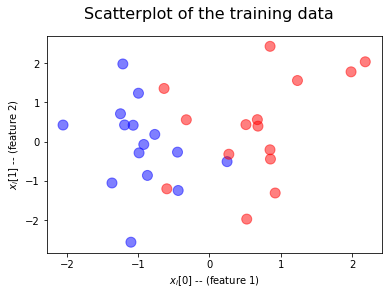

In [7]:
plot_dataset('Scatterplot of the training data', train_x, train_labels)

### Определяем архитектуру сети

In [8]:
x = tf.placeholder(tf.float32,shape=[None,2])
y_ = tf.placeholder(tf.float32,shape=[None, 2])

W = tf.Variable(tf.zeros([2,2]))
b = tf.Variable(tf.zeros([2]))

y = tf.nn.softmax(tf.matmul(x, W) + b)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

train_step = tf.train.AdamOptimizer(0.01).minimize(cross_entropy)
#train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:
train_labels_onehot=np.eye(2)[train_labels]
test_labels_onehot=np.eye(2)[test_labels]

In [10]:
#Create the session
sess = tf.InteractiveSession()
#Initialize the variables
tf.global_variables_initializer().run()

#Set the epoch(number of iterations)
epoch = 1000

#Train the model
for step in range(epoch):
    sess.run([train_step,cross_entropy], feed_dict={x: train_x, y_:train_labels_onehot})

In [11]:
sess.run(accuracy,feed_dict={x:test_x, y_:test_labels_onehot})

0.76

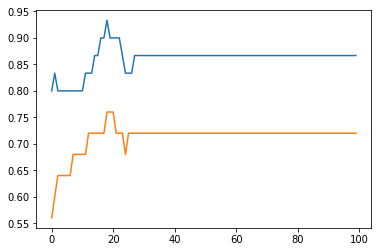

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

#Initialize the variables
tf.global_variables_initializer().run()

#Set the epoch(number of iterations)
epoch = 100

acc=[]

#Train the model
for step in range(epoch):
    for _ in range(2):
        perm = np.random.permutation(len(train_x))
        train_x = train_x[perm]
        train_labels_onehot = train_labels_onehot[perm]
        _,_ = sess.run([train_step,cross_entropy], feed_dict={x: train_x, y_:train_labels_onehot})
    tr_acc = sess.run(accuracy, feed_dict={x: train_x, y_:train_labels_onehot})
    val_acc = sess.run(accuracy,feed_dict={x:test_x, y_: test_labels_onehot})
    acc.append([tr_acc,val_acc])
    
acc = np.array(acc)

plt.plot(acc[:,0])
plt.plot(acc[:,1])
plt.show()

## Выводы

* Tensorflow позволяет более гибко определять, где происходят вычисления
* Описание сетей в базовом Tensorflow очень низкоуровневое
* Есть более удобные средства для работы с данными (`td.Data`), со слоями (`tf.layers`)
* Для массового использования нейросетей Google рекомендует **Keras**

## Keras - упрощение и унификация
### Deep Learning for Humans

* Работает поверх Tensorflow, CNTK или Theano
* Оперирует нейросетями на уровне слоёв
* Включает упрощённый "обучатель", средства работы с типовыми данными (картинками, ...)
* Много готовых примеров
* Functional API vs. Sequential API - очень похоже на CNTK!

Книжка от создателя Keras: [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)

In [13]:
import keras

model = keras.models.Sequential()
model.add(keras.layers.Dense(16, input_shape=(2,)))
model.add(keras.layers.Activation("sigmoid"))
model.add(keras.layers.Dense(2))
model.add(keras.layers.Activation("softmax"))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()
model.fit(train_x, train_labels_onehot, epochs=13, batch_size=1, verbose=1)
loss, accuracy = model.evaluate(test_x, test_labels_onehot, verbose=1)
print("Final accuracy = %f" % accuracy)

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                48        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________
Epoch 1/13
30/30 [==============================] - 0s - loss: 0.8097 - acc: 0.5000        
Epoch 2/13
30/30 [==============================] - 0s - loss: 0.7528 - acc: 0.5000         
Epoch 3/13
30/30 [==============================] - 0s - loss: 0.6964 - acc: 0.5000     
Epoc

### Выводы

* Для типовых задач имеет смысл использовать Keras (с Tensorflow backend)
* CNTK хорош для обработки последовательностей/текста, но меньше примеров
* Для исследований подходит Tensorflow (как наиболее гибкий), но иногда удаётся отделаться сочетанием TF+Keras
* Также стоит посмотреть на PyTorch, это "восходящая звезда"